In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain.agents import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage
from typing import List, TypedDict
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from IPython.display import Image, display
from langchain.embeddings import OpenAIEmbeddings
from langchain.tools import tool
from serpapi import GoogleSearch
import os
from langchain_community.tools import TavilySearchResults
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader

In [195]:
from dotenv import load_dotenv
import os 
load_dotenv('.env')

True

In [196]:
from langchain_core.chat_history import InMemoryChatMessageHistory
chat_history = InMemoryChatMessageHistory()

In [197]:
import operator
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
llm = ChatOpenAI(model="gpt-4o")

In [198]:
llm.invoke("hãy cho tôi biết thêm thông tin về nhà hàng Mi Quang Ba Mua")

AIMessage(content='Mì Quảng Bà Mua là một nhà hàng nổi tiếng tại Đà Nẵng, Việt Nam, chuyên phục vụ món Mì Quảng - một đặc sản nổi tiếng của miền Trung Việt Nam. Nhà hàng này được nhiều người biết đến bởi hương vị đậm đà, nguyên liệu tươi ngon và phong cách phục vụ thân thiện.\n\n### Đặc điểm nổi bật của Mì Quảng Bà Mua:\n1. **Hương vị độc đáo:** Mì Quảng tại đây thường được chế biến từ các nguyên liệu như tôm, thịt gà, thịt heo, hoặc cá lóc, kết hợp với nước dùng đậm đà và các loại rau sống tươi ngon.\n   \n2. **Không gian quán:** Nhà hàng thường có không gian rộng rãi, thoáng mát, tạo cảm giác thoải mái cho thực khách khi thưởng thức món ăn.\n\n3. **Dịch vụ:** Nhân viên phục vụ nhiệt tình, thân thiện, tạo cảm giác dễ chịu và thoải mái cho khách hàng.\n\n4. **Giá cả:** Mức giá tại đây được đánh giá là hợp lý so với chất lượng món ăn và dịch vụ.\n\n### Một số món ăn khác:\nNgoài Mì Quảng, nhà hàng cũng phục vụ một số món ăn đặc sản khác của Đà Nẵng và miền Trung, mang đến cho thực khách

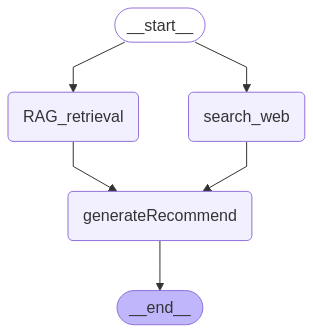

In [187]:
class RecommendState(MessagesState):
    query: str
    context: Annotated[list, operator.add]
def RAG_retrieval(state):
    """ Recommend hotels, restaurants based on user input """
    client = QdrantClient(host="localhost", port=6333)
    embeddings = OpenAIEmbeddings()
    
    # Load vectorstore từ collection đã tồn tại
    vectorstore = Qdrant(
        client=client,
        collection_name="hotels_and_ship_and_restaurants",
        embeddings=embeddings
    )
    context_items = vectorstore.similarity_search(state["query"], k=5)
    # Lấy nội dung của các tài liệu
    context_text = "\n".join(
        doc.page_content if hasattr(doc, "page_content") else str(doc)
        for sublist in context_items
        for doc in (sublist if isinstance(sublist, list) else [sublist])
    )
    return {"context": [context_text]}
def search_web(state):
    
    """ Retrieve docs from web search about everything related to tourism """

    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['query'])
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 
def generateRecommend(state):
    """ Generate a recommendation based on the context """
    context = "\n\n".join(str(item) for item in state["context"])
    query = state["messages"]
    prompt_template = """
Bạn là một chuyên gia du lịch và có kiến thức đầy đủ về các khách sạn tại Việt Nam. Bạn hãy trả lời câu hỏi của tôi dựa trên thông tin mà tôi đã cung cấp cho bạn. Các câu hỏi chủ yếu về các địa điểm du lịch, và cách xây dựng tour du lịch hợp lí bao gồm khách sạn, nhà hàng cũng như các địa điểm du lịch nổi tiếng gần đó.
Dưới đây là thông tin về một khách sạn mà tôi đã tìm thấy: {context}

Hãy cung cấp thông tin chi tiết về khách sạn, nhà hàng và tour du lịch theo như tôi yêu cầu, sử dụng các thông tin đã có và bổ sung thêm nếu có. Nếu có các thông tin về đường dẫn tới map hay facebook, website của khách sạn hay nhà hàng, hãy cung cấp cho tôi. Nếu không có thông tin nào, hãy nói là không có thông tin nào.
"""
    answer_instructions = prompt_template.format(context=context)
    response = llm.invoke([SystemMessage(content=answer_instructions)] + state['messages'])
    return {"messages": response}
    
rs_builder = StateGraph(RecommendState)
rs_builder.add_node("RAG_retrieval", RAG_retrieval)
rs_builder.add_node("search_web", search_web)
rs_builder.add_node("generateRecommend", generateRecommend)

rs_builder.add_edge(START, "RAG_retrieval")
rs_builder.add_edge(START, "search_web")
rs_builder.add_edge("RAG_retrieval", "generateRecommend")
rs_builder.add_edge("search_web", "generateRecommend")
rs_builder.add_edge("generateRecommend", END)
rs_graph = rs_builder.compile()

display(Image(rs_graph.get_graph().draw_mermaid_png()))

In [188]:
messages = [HumanMessage(content="thông tin về Ninh Bình Legend Hotel, Ninh Bình")]
query = "thông tin về Ninh Bình Legend Hotel, Ninh Bình"
result = rs_graph.invoke({"messages": messages, "query": query})
result['messages']

[HumanMessage(content='thông tin về Ninh Bình Legend Hotel, Ninh Bình', additional_kwargs={}, response_metadata={}, id='ea97ffc6-3132-447b-9b7e-2a6eea3c1fe5'),
 AIMessage(content='Khách sạn Ninh Bình Legend Hotel là một cơ sở đẳng cấp tọa lạc tại Ninh Bình, có tổng cộng 268 phòng và được quản lý bởi Công Ty TNHH Khách Sạn Thuỳ Anh Ninh Bình Legend. Đây là khách sạn đạt tiêu chuẩn 5 sao đầu tiên tại Ninh Bình, khai trương vào năm 2010. Nằm tại địa chỉ Đường Lê Thái Tổ, Khu Tiền Đồng - Phường Ninh Khánh, Thành phố Ninh Bình, Tỉnh Ninh Bình, khách sạn mang đến cho du khách một không gian lưu trú tinh tế và đẳng cấp với cảnh quan bao quát toàn cảnh Ninh Bình.\n\nCác tiện ích nổi bật của khách sạn bao gồm phòng có bồn tắm, lễ tân 24h, Wi-Fi miễn phí, hồ bơi ngoài trời, nhà hàng, ban công/cửa sổ với tầm nhìn rộng mở. Đây cũng là một trung tâm tổ chức hội nghị và sự kiện hiện đại với sức chứa lên đến 2.500 khách.\n\nNinh Bình Legend Hotel không chỉ là điểm đến nghỉ dưỡng lý tưởng mà còn là đố

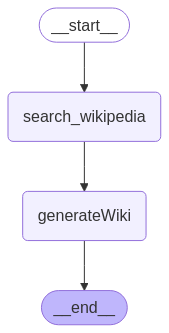

In [148]:
class WikiState(MessagesState):
    query: str
    context: Annotated[list, operator.add]
def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['query'], 
                                  load_max_docs=6).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}     
def generateWiki(state):
    """ Generate a recommendation based on the context """
    query = state["query"]
    context = state["context"]
    prompt_template = """
Bạn là một chuyên gia trả lời câu hỏi có sẵn từ wikipedia. Bạn đã nhận được dữ liệu từ wikipedia như sau: {context}

Hãy phân tích, tổng hợp để trả lời câu hỏi của người dùng."""
    answer_instructions = prompt_template.format(context=context)
    response = llm.invoke([SystemMessage(content=answer_instructions)] + state['messages'])
    return {"messages": response}
    
ws_builder = StateGraph(WikiState)
ws_builder.add_node("search_wikipedia", search_wikipedia)
ws_builder.add_node("generateWiki", generateWiki)
ws_builder.add_edge(START, "search_wikipedia")
ws_builder.add_edge("search_wikipedia", "generateWiki")
ws_builder.add_edge("generateWiki", END)
ws_graph = ws_builder.compile()
display(Image(ws_graph.get_graph().draw_mermaid_png()))

In [149]:
messages = [HumanMessage(content="Đà Nẵng có những gì nổi tiếng")]
result = ws_graph.invoke({"query": "Đà Nẵng có những gì nổi tiếng", "messages": messages})
print(result['messages'])

[HumanMessage(content='Đà Nẵng có những gì nổi tiếng', additional_kwargs={}, response_metadata={}, id='f81c9525-b843-4bc9-9d94-82945f4ac0e0'), AIMessage(content='Đà Nẵng có nhiều địa điểm và đặc điểm nổi tiếng, bao gồm:\n\n1. **Vị trí địa lý và cảng biển**: Đà Nẵng nằm trên bờ biển Nam Trung Bộ của Việt Nam, tại cửa sông Hàn. Đây là một trong những thành phố cảng quan trọng của Việt Nam, có cảng biển được che chắn tốt và dễ tiếp cận.\n\n2. **Trung tâm thương mại và giáo dục**: Đà Nẵng là trung tâm thương mại và giáo dục của miền Trung Việt Nam và là thành phố lớn nhất trong khu vực này.\n\n3. **Di sản văn hóa thế giới**: Đà Nẵng nằm trong khoảng cách gần (chỉ khoảng 100 km) với nhiều Di sản Văn hóa Thế giới của UNESCO, bao gồm Cố đô Huế, Phố cổ Hội An và Thánh địa Mỹ Sơn.\n\n4. **Danh lam thắng cảnh**: Thành phố nổi tiếng với các bãi biển đẹp như Bãi biển Mỹ Khê và nhiều địa điểm du lịch nổi tiếng như Ngũ Hành Sơn và bán đảo Sơn Trà.\n\n5. **Sự kiện quốc tế**: Đà Nẵng đã từng là nơi tổ

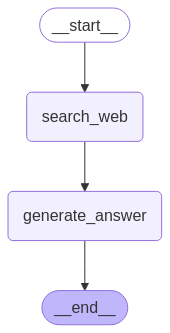

In [191]:
class SearchState(MessagesState):
    query: str
    context: Annotated[list, operator.add]
    answer: str

def search_web(state):
    """ Retrieve docs from web search about everything """
    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['query'])
    print(search_docs)
    print(type(search_docs))
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    print(type(formatted_search_docs))
    return {"context": [formatted_search_docs]}
    
def generate_answer(state):
    """ Generate a recommendation based on the context """
    query = state["query"]
    context = state["context"]
    prompt_template = """
Bạn là một chuyên gia trả lời câu hỏi có sẵn từ google. Bạn đã nhận được dữ liệu từ google như sau: {context}"""
    answer_instructions = prompt_template.format(context=context)
    print(state['messages'])
    response = llm.invoke([SystemMessage(content=answer_instructions)] + state['messages'])
    return {"messages": response}

search_builder = StateGraph(SearchState)
search_builder.add_node("search_web", search_web)
search_builder.add_node("generate_answer", generate_answer)
search_builder.add_edge(START, "search_web")
search_builder.add_edge("search_web", "generate_answer")
search_builder.add_edge("generate_answer", END)
search_graph = search_builder.compile()
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [193]:
messages = [HumanMessage(content="Có nên đi chơi Vinhomes Ocean Park không?")]
result = search_graph.invoke({"query": "Có nên đi chơi Vinhomes Ocean Park không?", "messages": messages})
print(result['messages'])

[{'title': 'Chơi gì ở Ocean Parks | Bật mí kinh nghiệm từ A-Z - Vinhomes Market', 'url': 'https://market.vinhomes.vn/blog/choi-gi-o-vinhomes-ocean-park', 'content': 'Khám phá\n\nVinClub\n\nChương trình khách hàng thân thiết tập đoàn Vingroup. Xem ưu đãi thành viên tại đây\n\n\n\nTin tức\n\nChơi gì ở Vinhomes Ocean Park? Bật mí kinh nghiệm từ A-Z\n\n\n\nCác cặp đôi, gia đình, nhóm bạn có thể chơi gì ở Vinhomes Ocean Park? Vinhomes Ocean Park được mệnh danh là Thành phố biển hồ, mở ra xu hướng “du lịch biển trong tuần” cho cộng đồng năng động Hà Thành. Bài viết sau sẽ bật mí những bí quyết cho một buổi đi chơi trọn vẹn tại Vinhomes Ocean Park. [...] Các cư dân, du khách có thể chơi gì ở Vinhomes Ocean Park? Chủ đầu tư đã phát triển rất nhiều hoạt động vui chơi - giải trí độc đáo đang chờ đợi khách hàng đến khám phá.\n\nBiển hồ nhân tạo nước ngọt\n\nHồ Ngọc Trai hay biển hồ nhân tạo nước ngọt Vinhomes Ocean Park có quy mô tổng diện tích lên tới 24,5 ha. Không khí tại hồ Ngọc Trai luôn tho

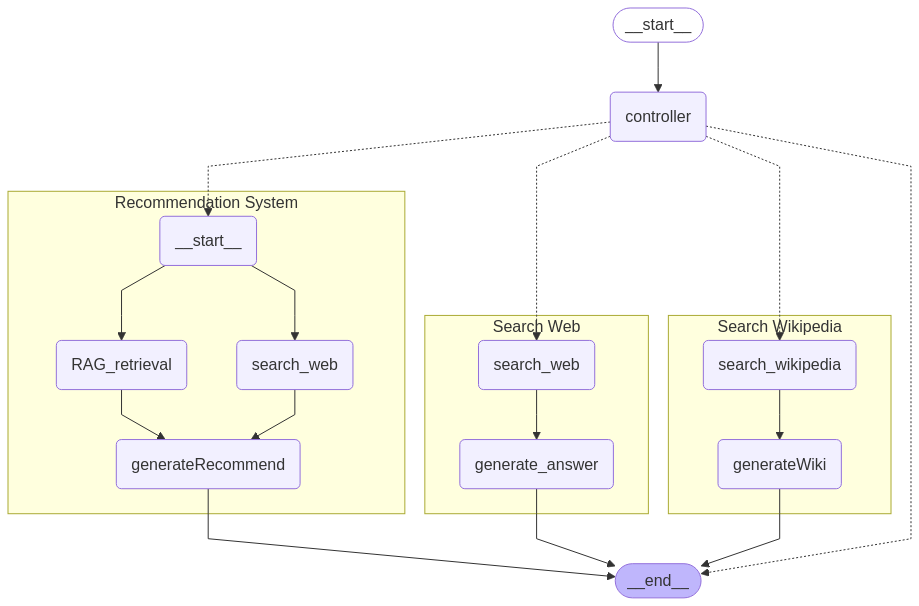

In [177]:
class EntryGraphState(MessagesState):
    query: str
    context: Annotated[list, operator.add]
    subgraph_name: str
    summary: str
    
def controller(state):
    """ Controller to decide which subgraph to use """
    prompt_template = """Bạn là một chuyên gia dự đoán các câu hỏi của người dùng,
    dựa trên câu hỏi của người dùng, hãy quyết định subgraph nào nên được kích hoạt để Agent có thể 
    đưa ra câu trả lời tốt nhất cho người dùng.
    Hãy trả lời với một trong các subgraph sau: `Recommendation System`, `Search Wikipedia` và `Search Web`.
    Nếu câu hỏi đưa vào liên quan tới yêu cầu xây dựng tour du lịch, hỏi đáp về nhà hàng, khách sạn cụ thể, hãy gọi tới `Recommendation System`.
    Nếu câu hỏi đưa vào liên quan tới yêu cầu tìm kiếm thông tin từ wikipedia, hãy gọi tới `Search Wikipedia`.
    Nếu câu hỏi đưa vào liên quan tới yêu cầu tìm kiếm thông tin từ google, hãy gọi tới `Search Web`.
    Nếu không có subgraph nào phù hợp, hãy gọi tới `Search Web`.
    LƯU Ý: CHỈ ĐƯA RA MỘT TRONG CÁC GIÁ TRỊ NÀY, KHÔNG ĐƯA RA CÁC GIÁ TRỊ KHÁC.
    Hãy đưa ra câu trả lời ngắn gọn và súc tích.
    Đây là câu hỏi của người dùng: {query}"""
    messages = llm.invoke(prompt_template.format(query=state["query"]))
    if messages.content == "Recommendation System":
        print("Recommendation System")
        return {"subgraph_name": "Recommendation System"}
    elif messages.content == "Search Wikipedia":
        print("Search Wikipedia")
        return {"subgraph_name": "Search Wikipedia"}
    elif messages.content == "Search Web":
        print("Search Web")
        return {"subgraph_name": "Search Web"}
    return {"subgraph_name": "Search Web"}

def condition_tools(state):
    if state['subgraph_name'] == "Recommendation System":
        return "Recommendation System"
    elif state['subgraph_name'] == "Search Wikipedia":
        return "Search Wikipedia"
    elif state['subgraph_name'] == "Search Web":
        return "Search Web"
    else:
        return "Search Web"
      
builder = StateGraph(EntryGraphState)
builder.add_node("controller", controller)
builder.add_node("Recommendation System", rs_builder.compile())
builder.add_node("Search Wikipedia", ws_builder.compile())
builder.add_node("Search Web", search_builder.compile())

builder.add_edge(START, "controller")
builder.add_conditional_edges(
    "controller",
    condition_tools
)
builder.add_edge("Recommendation System", END)
builder.add_edge("Search Wikipedia", END)
builder.add_edge("Search Web", END)
graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [199]:
messages = [HumanMessage(content="Tìm kiếm thông tin về khách sạn Ninh Bình Legend Hotel, Ninh Bình")]
result = graph.invoke({"query": "Tìm kiếm thông tin về khách sạn Ninh Bình Legend Hotel, Ninh Bình", "messages": messages})
print(result['messages'])

Recommendation System
[HumanMessage(content='Tìm kiếm thông tin về khách sạn Ninh Bình Legend Hotel, Ninh Bình', additional_kwargs={}, response_metadata={}, id='5742ab67-bdbc-4dca-ba69-4dcd37123c76'), AIMessage(content='Khách sạn Ninh Bình Legend Hotel là một khách sạn đạt tiêu chuẩn 5 sao đầu tiên tại Ninh Bình, nổi bật với 268 phòng nghỉ cao cấp được trang bị cơ sở vật chất và tiện nghi hiện đại. Khách sạn được xây dựng vào năm 2007 và khai trương vào tháng 3 năm 2010. Nó nằm tại địa chỉ đường Lê Thái Tổ, Khu Tiền Đồng - Phường Ninh Khánh, TP. Ninh Bình, Tỉnh Ninh Bình.\n\n**Thông tin chi tiết:**\n\n- **Tiện ích:** Phòng có bồn tắm, Lễ tân 24h, Wifi miễn phí, Bể bơi ngoài trời, Nhà hàng, Ban công/Cửa sổ.\n- **Giá phòng:** 1,550,000 đồng.\n- **Quản lý bởi:** Công ty TNHH Khách Sạn Thuỳ Anh Ninh Bình Legend.\n- **Website:** [Ninh Binh Legend Hotel](https://ninhbinhlegendhotel.com/)\n- **Đường dẫn bản đồ:** [Google Maps](https://maps.app.goo.gl/cmcKohNWmDTbHEvB9)\n\n**Nhà hàng gần khách